# **<font style="color:rgb(0, 133, 202)">Audio Classification Task - Speech Commands </font>**

Speech recognition has become an essential component of modern human-computer interaction, enabling voice-controlled assistants, smart home devices, and accessibility tools. To develop accurate and efficient speech recognition models, high-quality datasets are crucial.

The **Speech Commands Dataset**, released by TensorFlow, provides a rich collection of 40,000 one-second audio recordings, containing **30 distinct words** spoken by thousands of different individuals. This dataset is specifically designed for training machine learning models to recognize simple spoken commands, making it an excellent resource for building open-source voice interfaces.

The dataset primarily focuses on:
-  **20 core command words:** *yes, no, up, down, left, right, on, off, stop, go*, and the digits *0-9*
- **10 auxiliary words:** *bed, bird, cat, dog, happy, house, marvel, Sheila, tree, wow*.

The auxiliary words help models distinguish between recognized and unrecognized words.

Each recording is stored as a *.wav* file, with words organized into corresponding folders based on their labels.

A key feature of this dataset is the **diversity** in speaker accents, pronunciations, and background noise, making it well-suited for training robust speech recognition models that can generalize to real-world conditions.

The **goal** of this project is to train models that can accurately recognize the **20 command words**.

**Reference:** [Link](https://www.kaggle.com/datasets/jbuchner/synthetic-speech-commands-dataset)

## **Import libraries**


In [1]:
from google.colab import drive
import zipfile
from shutil import copyfile
import os

import random
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
import itertools

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## **Loading**

The following code is aimed at importing the files. It follows three main steps:

1. **Mounting Google Drive** : The script first mounts Google Drive to allow access to the ZIP file stored in the Google Drive.

2. **Copying the ZIP File** : It copies a specified ZIP file from Google Drive to the Colab environment, enabling local processing.

3. **Extracting the ZIP File** : Finally, the script extracts the contents of the ZIP file into the current working directory, making the files available for further use.

In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Copy the .zip file from Google Drive to the current directory
source_path = '/content/gdrive/My Drive/mono_dim.zip'  # Adjust the path to your .zip file
destination_path = 'mono_dim.zip'

# Copy the file to Colab's local environment
copyfile(source_path, destination_path)

# Extract the .zip file
with zipfile.ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall()  # Extract all the contents of the .zip file
    print("Extraction completed!")

Mounted at /content/gdrive
Extraction completed!


## **Analysis**

We will use all 30 words for training, including both core commands and auxiliary words. The auxiliary words provide valuable data for the model to learn distinctions between different spoken terms, improving its ability to handle real-world variations in speech.

In [3]:
dataset_path = "augmented_dataset/augmented_dataset"

# Get all word folders
word_folders = sorted(os.listdir(dataset_path))
num_words = len(word_folders)
print(f"Total word categories: {num_words}")

word_stats = {}
long_audio_files = []
all_audio_files = []  # List to store all audio file paths

total_audio_count = 0  # Counter for total number of audio files

# Analyze audio files in each folder
for word in word_folders:
    word_path = os.path.join(dataset_path, word)
    if not os.path.isdir(word_path):
        continue

    audio_files = [f for f in os.listdir(word_path) if f.endswith('.wav')]
    num_files = len(audio_files)
    total_audio_count += num_files  # Update total audio count

    durations = []
    for file in audio_files:
        file_path = os.path.join(word_path, file)
        try:
            y, sr = librosa.load(file_path, sr=None)
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append(duration)

            # Add audio file to the list
            all_audio_files.append(file_path)

            # Check if the audio is longer than 1 second
            if duration > 1:
                long_audio_files.append(file_path)

        except Exception as e:
            print(f"Error loading {file}: {e}")

    # Store statistics
    word_stats[word] = {
        "num_files": num_files,
        "durations": durations
    }

# Print the total number of audio files
print(f"Total number of audio files: {total_audio_count}")


Total word categories: 30
Total number of audio files: 41849


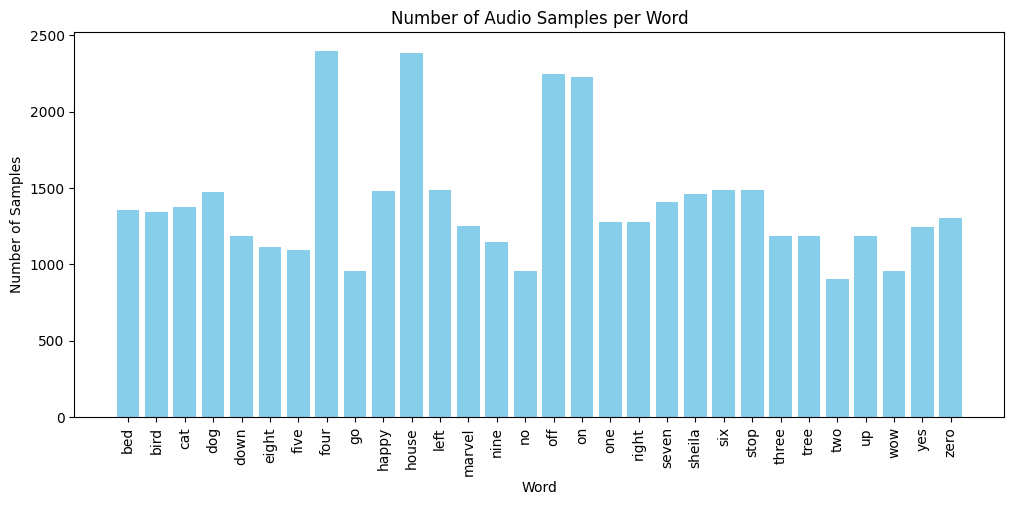

In [4]:
# Plot number of samples per word
plt.figure(figsize=(12, 5))
plt.bar(word_stats.keys(), [stats["num_files"] for stats in word_stats.values()], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Number of Samples")
plt.title("Number of Audio Samples per Word")
plt.show()

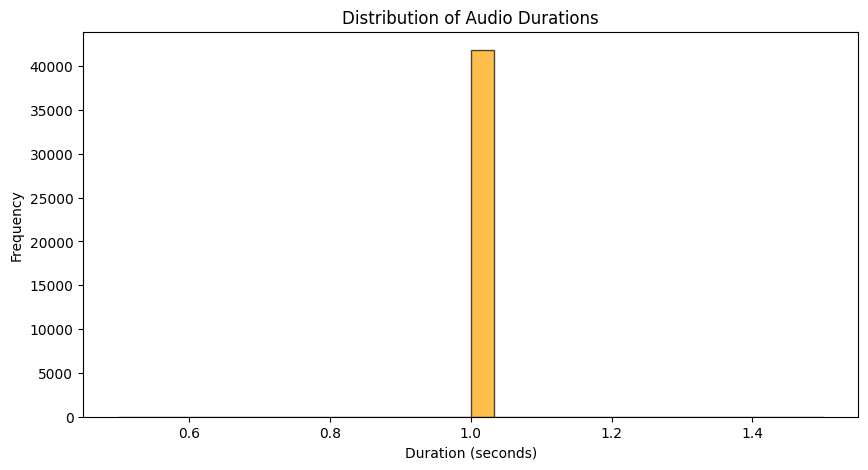

In [5]:
# Plot histogram of audio durations
all_durations = np.concatenate([stats["durations"] for stats in word_stats.values() if stats["durations"]])
plt.figure(figsize=(10, 5))
plt.hist(all_durations, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Distribution of Audio Durations")
plt.show()

In [6]:
# Print summary statistics
print("\nTOTAL AUDIOS PER CLASS:")
for word, stats in word_stats.items():
    print(f"{word}: {stats['num_files']} files")


TOTAL AUDIOS PER CLASS:
bed: 1356 files
bird: 1346 files
cat: 1378 files
dog: 1474 files
down: 1188 files
eight: 1113 files
five: 1092 files
four: 2400 files
go: 960 files
happy: 1481 files
house: 2382 files
left: 1485 files
marvel: 1253 files
nine: 1144 files
no: 957 files
off: 2244 files
on: 2228 files
one: 1276 files
right: 1276 files
seven: 1411 files
sheila: 1463 files
six: 1485 files
stop: 1485 files
three: 1188 files
tree: 1188 files
two: 902 files
up: 1187 files
wow: 957 files
yes: 1244 files
zero: 1306 files


Note that there are any audio files longer than 1 second.

In [7]:
if long_audio_files:
    print("\nFiles longer than 1 second:")
    for audio in long_audio_files:
        print(audio)
else:
    print("\nNo audio files longer than 1 second.")


No audio files longer than 1 second.


The **Speech Commands Dataset** used in this project consists of **30 word categories** and a total of **41,849 audio files**. Each audio file is a **one-second** recording of a spoken word, ensuring consistency in duration across the dataset.


The dataset is well-balanced, with each word category containing a substantial number of samples. Below are some key statistics:

- The words *four* and *house* have the highest number of recordings, with 2.400 and 2.382 files, respectively.

- Common commands like *stop* (1,485 files), *go* (960 files) and *up* (1,187 files) are well-represented.

- Digits from 0 to 9 are also included, with an average of around 1,200 files per digit.

- Auxiliary words such as *bed* (1,356 files), *bird* (1,346 files) and *cat* (1,378 files) help in distinguishing between different speech patterns.


### **Hearing and plotting random audios**

The following code allows to hear and plot the waveform of 3 random audios


Playing Audio 1: augmented_dataset/augmented_dataset/happy/109.wav


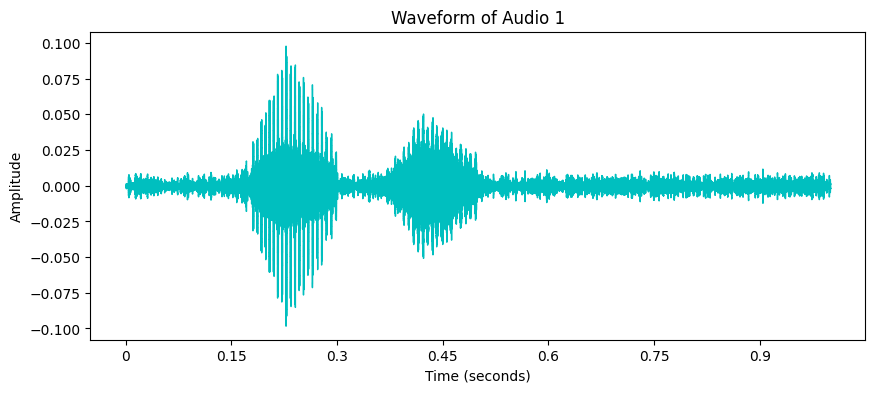


Playing Audio 2: augmented_dataset/augmented_dataset/two/947.wav


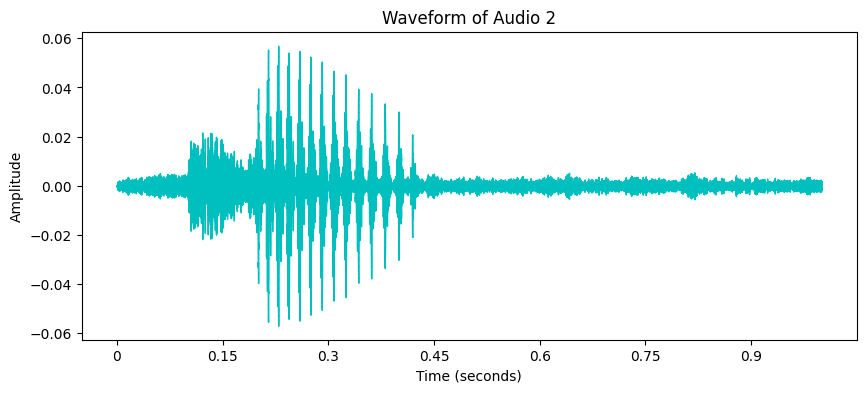


Playing Audio 3: augmented_dataset/augmented_dataset/up/544.wav


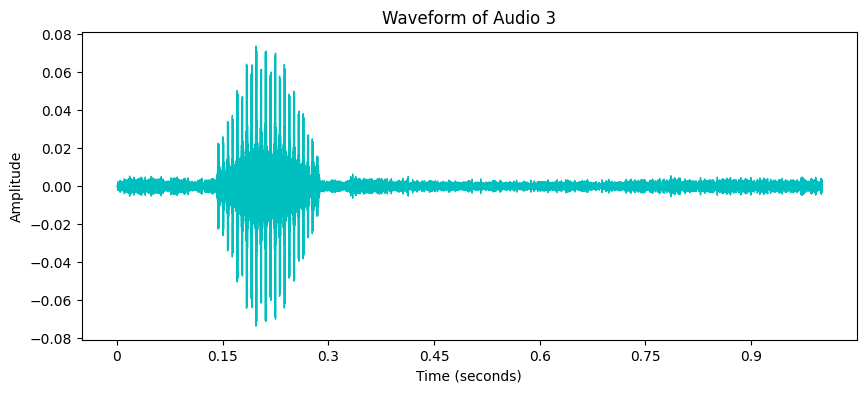

In [8]:
selected_audios = random.sample(all_audio_files, 3)

# Play the 3 random audio files
for i, audio_path in enumerate(selected_audios, 1):
    y, sr = librosa.load(audio_path, sr=None)
    print(f"\nPlaying Audio {i}: {audio_path}")
    ipd.display(ipd.Audio(y, rate=sr))

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr, color='c')
    plt.title(f"Waveform of Audio {i}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

## **Training a net from scratch**

### **MFCC (Mel-Frequency Cepstral Coefficients)**


**Mel-Frequency Cepstral Coefficients (MFCCs)** are widely used in speech recognition because they capture the essential *features of human speech* while removing irrelevant information. Some key reasons to use MFCC:

- **Mimics human hearing (Mel Scale)** : The human ear is more sensitive to lower frequencies than higher ones. MFCC applies a Mel scale filter bank to mimic human perception.

- **Removes redundant information (Cepstral Analysis)** : Raw waveforms contain a lot of unnecessary noise. MFCC focuses on speech-related features while reducing noise.

- **Effective for short-time analysis** : Speech signals change over time. MFCC uses short frames (e.g., 25ms) to capture speech dynamics.

- **Compact and meaningful representation** : Instead of raw waveforms (high-dimensional), MFCC provides a small set of coefficients that efficiently represent speech. This helps models to learn faster and generalize better.

To train a speech recognition model, we extract the MFCCs from each audio file. Each audio file is converted into a **13-dimensional MFCC feature representation**, padded or truncated to ensure a fixed length of 40 time frames for uniform input size.

Once the MFCC features are extracted, we map each word to a numerical index and prepare the dataset, splitting into 80% training and 20% testing, ensuring a balanced distribution of words for model evaluation.

In [9]:
# Mapping words to indices
word_to_index = {word: i for i, word in enumerate(word_folders)}
index_to_word = {i: word for word, i in word_to_index.items()}


# Function to extract MFCC features
def extract_mfcc(file_path, max_pad=40):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

        # Padding or truncating MFCCs
        if mfcc.shape[1] < max_pad:
            pad_width = max_pad - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad]

        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Prepare dataset (MFCC features and labels)
X, y = [], []
for word in word_folders:
    word_path = os.path.join(dataset_path, word)
    for file in os.listdir(word_path):
        if file.endswith('.wav'):
            file_path = os.path.join(word_path, file)
            mfcc = extract_mfcc(file_path)
            if mfcc is not None:
                X.append(mfcc)
                y.append(word_to_index[word])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape for CNN input (add channel dimension)
X = X[..., np.newaxis]

# One-hot encode labels
y = to_categorical(y, num_classes=len(word_folders))

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **Model 1**

A first Convolutional Neural Network (CNN) is built to capture local patterns in MFCC representations. The model consists of:

- **Convolutional Layers**: Two Conv2D layers (with 32 and 64 filters) extract important spectral features from the input MFCCs.

- **MaxPooling Layers**: Reduce dimensionality while preserving important frequency components.

- **Flattening Layer**: Converts the extracted features into a 1D vector for classification.

- **Fully Connected Layers**: A dense layer (128 neurons) with ReLU activation processes high-level features.

- **Dropout Layer**: Prevents overfitting by randomly deactivating neurons during training.

- **Output Layer**: Uses a softmax activation function to classify the input into one of the 30 word categories.

The model is compiled with **Adam optimization** and **categorical cross-entropy loss**, suitable for multi-class classification. Training is performed over 35 epochs with batch size 32.

In [10]:
# Build CNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(13, 40, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(word_folders), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test))

# model.save('speech_recognition_model_mfcc_1.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4514 - loss: 3.0266 - val_accuracy: 0.9151 - val_loss: 0.2738
Epoch 2/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8997 - loss: 0.3048 - val_accuracy: 0.9362 - val_loss: 0.1936
Epoch 3/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9416 - loss: 0.1782 - val_accuracy: 0.9706 - val_loss: 0.0909
Epoch 4/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9581 - loss: 0.1244 - val_accuracy: 0.9732 - val_loss: 0.0880
Epoch 5/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9738 - loss: 0.0875 - val_accuracy: 0.9778 - val_loss: 0.0716
Epoch 6/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9729 - loss: 0.0818 - val_accuracy: 0.9741 - val_loss: 0.0817
Epoch 7/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9764 - loss: 0.0722 - val_accuracy: 0.9811 - val_loss: 0.0597
Epoch 8/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9793 - loss: 0.0689 -

##### **Evaluation**

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9890 - loss: 0.0680
Test Accuracy: 98.83%


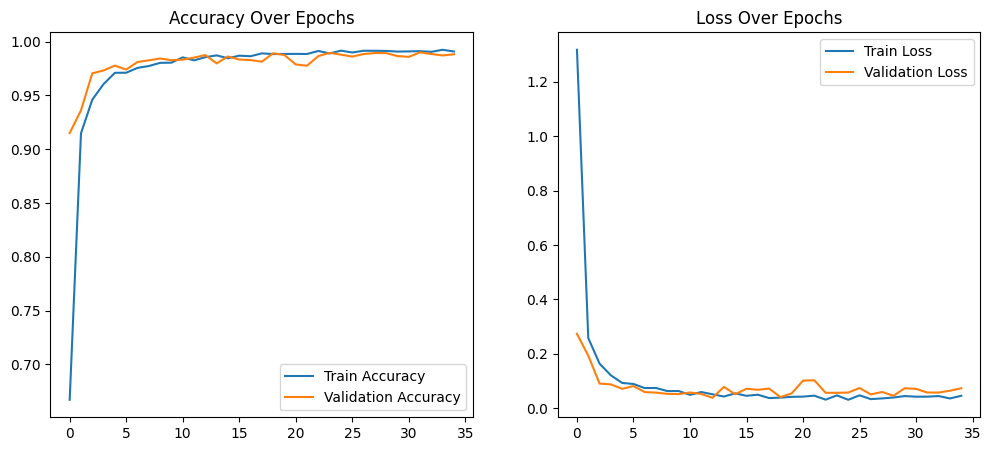

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       284
           1       0.99      0.99      0.99       283
           2       1.00      0.98      0.99       299
           3       0.99      0.99      0.99       296
           4       0.99      0.98      0.98       256
           5       0.98      0.99      0.99       243
           6       1.00      0.99      0.99       222
           7       0.99      0.98      0.98       457
           8       0.98      0.99      0.99       193
           9       0.99      0.99      0.99       304
          10       0.99      0.99      0.99       487
          11       1.00      1.00      1.00       274
          12       0.99      0.99      0.99       265
          13       0.99      0.99      0.99       234
          14       0.99      0.99      0.99       202
          15       0.99      0.99      0.99       453
          16     

In [11]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Define class labels (assuming 30 classes)
class_labels = [str(i) for i in range(30)]  # Modify if class labels are different

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

The accuracy curve (left) shows that both training and validation accuracy increase rapidly, reaching over **95% accuracy** within the first few epochs. This suggests that the model is learning effectively without significant underfitting.

The loss curve (right) decreases sharply within the first few epochs and stabilizes at a low value. The small fluctuations in validation loss suggest some variability, but no severe overfitting is evident.

Overall, the model generalizes well, achieving high accuracy while maintaining low validation loss, making it well-suited for recognizing spoken commands.

#### **Model 2**

The architecture consists of:

- **Two convolutional layers** with ReLU activation and batch normalization, followed by max pooling to reduce dimensionality.

- A **fully connected (dense) layer** with 256 neurons, batch normalization, and ReLU activation to learn complex patterns.

- Another **dense layer with 128 neurons** to refine feature representations.

- A final **softmax layer** with 30 output nodes, corresponding to the 30-word categories.

The model is compiled using the **Adam optimizer** and **categorical cross-entropy loss**, ideal for multi-class classification. Additionally, **early stopping** is implemented to prevent overfitting, ensuring that training stops if validation loss stops improving.

In [12]:
# Build CNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(13, 40, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(30, activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=35,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# model.save('speech_recognition_model_mfcc_2.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.6192 - loss: 1.3870 - val_accuracy: 0.8977 - val_loss: 0.3359
Epoch 2/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9117 - loss: 0.2884 - val_accuracy: 0.9425 - val_loss: 0.1904
Epoch 3/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9440 - loss: 0.1762 - val_accuracy: 0.9532 - val_loss: 0.1476
Epoch 4/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9602 - loss: 0.1297 - val_accuracy: 0.9612 - val_loss: 0.1204
Epoch 5/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9697 - loss: 0.0977 - val_accuracy: 0.9497 - val_loss: 0.1730
Epoch 6/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9720 - loss: 0.0876 - val_accuracy: 0.9639 - val_loss: 0.1200
Epoch 7/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9746 - loss: 0.0790 - val_accuracy: 0.9688 - val_loss: 0.1006
Epoch 8/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9761 - loss: 0.0708 -

##### **Evaluation**

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9824 - loss: 0.0521
Test Accuracy: 98.32%


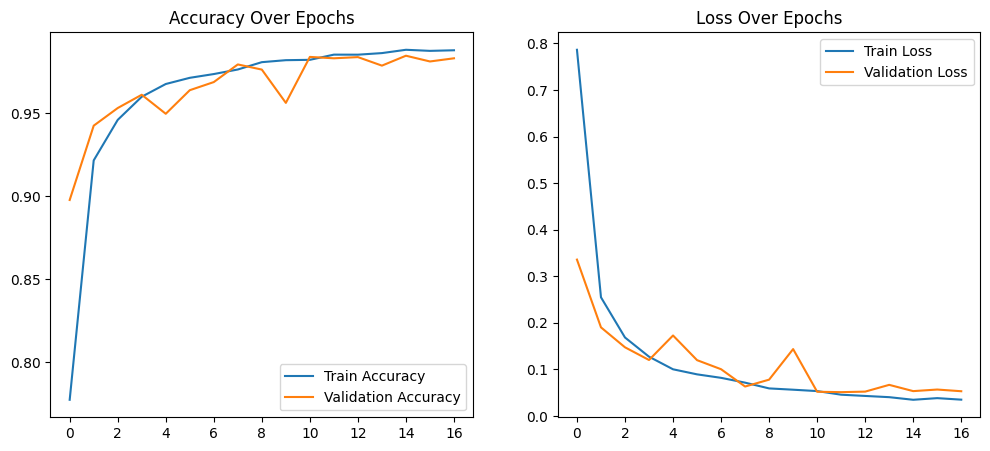

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       284
           1       0.98      0.99      0.98       283
           2       0.97      1.00      0.98       299
           3       0.99      0.98      0.98       296
           4       1.00      0.96      0.98       256
           5       0.99      0.96      0.97       243
           6       0.99      0.97      0.98       222
           7       0.97      0.99      0.98       457
           8       0.98      0.97      0.98       193
           9       0.97      1.00      0.98       304
          10       1.00      0.99      0.99       487
          11       1.00      0.99      1.00       274
          12       0.99      0.98      0.98       265
          13       1.00      0.96      0.98       234
          14       0.98      0.99      0.98       202
          15       0.99      1.00      0.99       453
          16     

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Define class labels (assuming 30 classes)
class_labels = [str(i) for i in range(30)]  # Modify if class labels are different

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

### **Spectrogram**

For audio classification tasks, a **Spectrogram** is a powerful tool because it transforms a raw audio signal into a **2D image-like structure**. The x-axis represents time, the y-axis represents frequency, and the intensity of the color represents the amplitude (or power) of each frequency component.

In this case, the **Mel-spectrogram** is used, which applies the Mel scale to the frequency axis, aligning with human auditory perception.

The *extract_spectrogram()* function generates these Mel-spectrograms, converting raw audio into a more useful format for machine learning models. These spectrograms are padded or truncated to ensure consistent dimensions, and the result is used as input for training models.

In [ ]:
# Function to extract spectrogram features
def extract_spectrogram(file_path, max_pad=40):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # Padding or truncating spectrograms
        if log_spectrogram.shape[1] < max_pad:
            pad_width = max_pad - log_spectrogram.shape[1]
            log_spectrogram = np.pad(log_spectrogram, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            log_spectrogram = log_spectrogram[:, :max_pad]

        return log_spectrogram
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Prepare dataset (Spectrogram features and labels)
X, y = [], []
for word in word_folders:
    word_path = os.path.join(dataset_path, word)
    for file in os.listdir(word_path):
        if file.endswith('.wav'):
            file_path = os.path.join(word_path, file)
            spectrogram = extract_spectrogram(file_path)
            if spectrogram is not None:
                X.append(spectrogram)
                y.append(word_to_index[word])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape for CNN input (add channel dimension)
X = X[..., np.newaxis]

# One-hot encode labels
y = to_categorical(y, num_classes=len(word_folders))

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

A CNN model is built to perform audio classification using the spectrogram features extracted earlier. The model consists of two convolutional layers with 32 and 64 filters, respectively, followed by batch normalization and max-pooling layers. These convolutional layers help to learn spatial hierarchies and patterns within the spectrogram images, which is essential for audio classification tasks. After flattening the feature maps, the model includes two dense layers: one with 128 units and a dropout layer for regularization to prevent overfitting, and another output layer with a softmax activation function to classify the input into one of the 30 categories.

The model is compiled using the **Adam optimizer** and **categorical crossentropy loss**.

The model is then trained on the training dataset for 35 epochs with validation to monitor performance on unseen data.

In [ ]:
# Build CNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 40, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(len(word_folders), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=35, batch_size=32, validation_data=(X_test, y_test))

# model.save('speech_recognition_model_spec.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6208 - loss: 1.4016 - val_accuracy: 0.9577 - val_loss: 0.1379
Epoch 2/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9564 - loss: 0.1320 - val_accuracy: 0.9687 - val_loss: 0.0955
Epoch 3/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9758 - loss: 0.0722 - val_accuracy: 0.9381 - val_loss: 0.2058
Epoch 4/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9822 - loss: 0.0569 - val_accuracy: 0.9307 - val_loss: 0.2312
Epoch 5/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9832 - loss: 0.0548 - val_accuracy: 0.9828 - val_loss: 0.0532
Epoch 6/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9871 - loss: 0.0391 - val_accuracy: 0.9222 - val_loss: 0.2531
Epoch 7/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9853 - loss: 0.0538 - val_accuracy: 0.9871 - val_loss: 0.0414
Epoch 8/35
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9914 - loss: 0.029

##### **Evaluation**

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9913 - loss: 0.0459
Test Accuracy: 99.13%


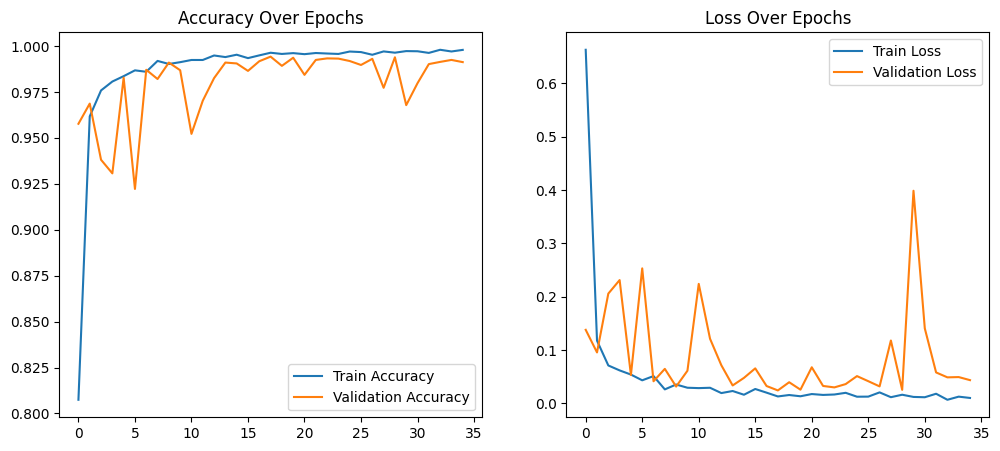

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       284
           1       1.00      0.98      0.99       283
           2       1.00      0.99      0.99       299
           3       0.98      0.99      0.99       296
           4       0.98      1.00      0.99       256
           5       1.00      0.97      0.98       243
           6       1.00      1.00      1.00       222
           7       1.00      1.00      1.00       457
           8       0.99      0.97      0.98       193
           9       1.00      1.00      1.00       304
          10       0.98      1.00      0.99       487
          11       0.97      1.00      0.99       274
          12       1.00      1.00      1.00       265
          13       0.98      0.98      0.98       234
          14       0.98      0.99      0.98       202
          15       0.98      1.00      0.99       453
          16     

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Define class labels (assuming 30 classes)
class_labels = [str(i) for i in range(30)]  # Modify if class labels are different

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

## **Fine Tuning (YAMNet)**

**Fine-tuning** can further improve classification performance. Fine-tuning involves unfreezing the top layers of the model and training them on the new dataset. This enables the model to adapt to the specific characteristics of the new audio classes, while still leveraging the pre-trained knowledge of YAMNet for general audio feature extraction. This approach helps in reducing the training time and improves the model's accuracy on the target task.

This code outlines the process of utilizing the pre-trained **YAMNet model** from TensorFlow Hub for audio classification tasks, with the option of fine-tuning for better performance.

The YAMNet model is designed for environmental sound classification, trained to recognize a wide range of audio classes. It processes raw audio waveforms and outputs embeddings that represent high-level features of the audio, which can be used for various downstream tasks such as classification. The model is pre-trained on a large audio dataset, enabling it to recognize a broad range of sounds with high accuracy.

For each audio sample, the raw waveform is processed by YAMNet, and **embeddings** are extracted. These embeddings are averaged across time steps to produce a fixed-length vector representation of the audio, which serves as a feature vector for classification.

In [ ]:
# Load YAMNet model from TensorFlow Hub
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet = hub.load(yamnet_model_handle)

# Function to extract YAMNet embeddings
def extract_yamnet_embedding(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        waveform = tf.convert_to_tensor(y, dtype=tf.float32)
        scores, embeddings, spectrogram = yamnet(waveform)
        return embeddings.numpy().mean(axis=0)  # Average over time steps
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load dataset
word_to_index = {word: i for i, word in enumerate(word_folders)}
X, y = [], []

for word in word_folders:
    word_path = os.path.join(dataset_path, word)
    for file in os.listdir(word_path):
        if file.endswith('.wav'):
            file_path = os.path.join(word_path, file)
            embedding = extract_yamnet_embedding(file_path)
            if embedding is not None:
                X.append(embedding)
                y.append(word_to_index[word])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
y = to_categorical(y, num_classes=len(word_folders))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In this part we are setting up and training a **Transfer Learning model** for audio classification, leveraging the embeddings extracted previously by the YAMNet model:

- **Input Layer:** The model receives an input of shape (1024,), which corresponds to the embedding size of the YAMNet model. These embeddings are already high-level features that capture meaningful information from the audio signal.

- **Dense Layer:** A dense layer with 256 units and ReLU activation is applied to learn complex relationships in the embedding space.

- **Dropout:** Dopout is applied with a rate of 0.2, to prevent overfitting by randomly setting some fraction of the weights to zero during training.

- **Output Layer:**  The softmax activation is used for multi-class classification as it returns a probability distribution over the classes.

For compilation the model uses the **Adam optimizer** and **categorical cross-entropy loss function**. e for multi-class classification problems.


Callbacks:

- **ReduceLROnPlateau:** It monitors the validation loss and reduces the learning rate by a factor of 0.5 if the validation loss does not improve for 2 consecutive epochs. This can help the model converge better during training by lowering the learning rate when it reaches a plateau.

- **EarlyStopping:** It monitors the validation loss and stops training early if the validation loss doesn't improve for 5 epochs.

In [ ]:
# Build Transfer Learning Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1024,)),  # YAMNet output embedding size
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(word_folders), activation='softmax')
])

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[lr_scheduler, early_stopping])

# model.save('speech_recognition_model_yamnet.h5')

Epoch 1/50
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.1577 - loss: 3.0504 - val_accuracy: 0.3182 - val_loss: 2.4079 - learning_rate: 0.0010
Epoch 2/50
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3199 - loss: 2.3641 - val_accuracy: 0.3705 - val_loss: 2.1718 - learning_rate: 0.0010
Epoch 3/50
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3717 - loss: 2.1446 - val_accuracy: 0.4000 - val_loss: 2.0520 - learning_rate: 0.0010
Epoch 4/50
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4152 - loss: 1.9907 - val_accuracy: 0.4223 - val_loss: 1.9367 - learning_rate: 0.0010
Epoch 5/50
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4386 - loss: 1.8869 - val_accuracy: 0.4401 - val_loss: 1.8507 - learning_rate: 0.0010
Epoch 6/50
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4638 - loss: 1.7985 - val_accuracy: 0.4695 - val_loss: 1.7699 - learning_rate: 0.0010
Epoch 7/50
1047/1047 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4788 - l

##### **Evaluation**

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6338 - loss: 1.2140
Test Accuracy: 62.96%


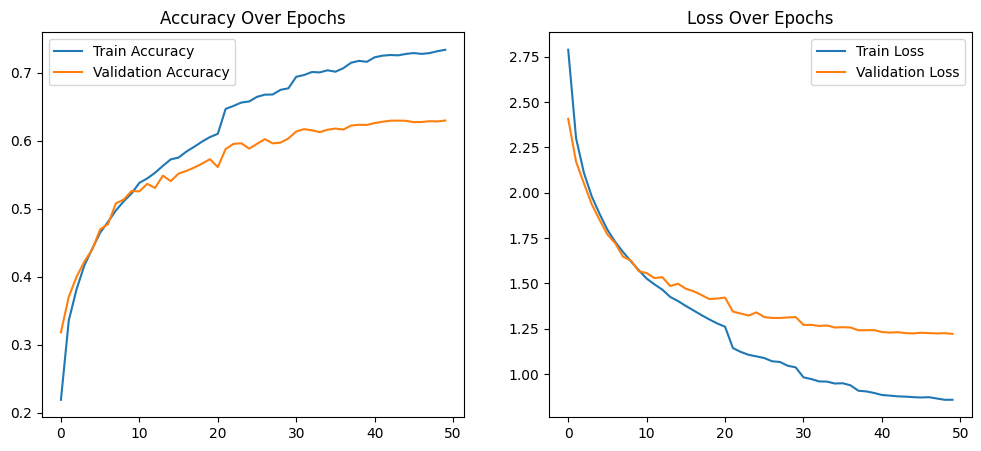

262/262 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       284
           1       0.59      0.53      0.55       283
           2       0.63      0.65      0.64       299
           3       0.57      0.57      0.57       296
           4       0.59      0.46      0.51       256
           5       0.53      0.44      0.48       243
           6       0.68      0.59      0.63       222
           7       0.56      0.67      0.61       457
           8       0.46      0.39      0.42       193
           9       0.71      0.74      0.72       304
          10       0.70      0.75      0.72       487
          11       0.59      0.68      0.63       274
          12       0.72      0.66      0.69       265
          13       0.62      0.62      0.62       234
          14       0.55      0.43      0.48       202
          15       0.56      0.70      0.62       453
          16     

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

# Get model predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Define class labels (assuming 30 classes)
class_labels = [str(i) for i in range(30)]  # Modify if class labels are different

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

The **accuracy plot** shows that both training and validation accuracy improve over time. However, after a certain point, the validation accuracy plateaus around 0.6, while the training accuracy continues to rise above 0.7. This suggests that the model may be overfitting, as it performs better on the training set than on the validation set.

The **loss plot** illustrates that both training and validation loss decreasing initially. However, while the training loss continues to decline, the validation loss stabilizes at a higher value, further indicating potential overfitting. The model may be learning patterns specific to the training data rather than generalizing well to unseen data.



##### **Prediction**

In [ ]:
# Path to new audio file
audio_file = "seven_audio.wav"

# Extract features from the new audio file
audio_yam = extract_yamnet_embedding(audio_file)

if audio_yam is not None:
    audio_yam = np.expand_dims(audio_yam, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(audio_yam)
    predicted_class = np.argmax(prediction)  # Get class index
    confidence = np.max(prediction)  # Get confidence score

    # Get the predicted label
    predicted_label = index_to_word[predicted_class]

    # Print the result
    print("\n🔹 Speech Recognition Result:")
    print(f"Predicted Class: {predicted_label}")
    print(f"Confidence Score: {confidence}")

else:
    print("Error processing the audio file. Please check the file format.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

🔹 Speech Recognition Result:
Predicted Class: seven
Confidence Score: 0.9988787770271301


## **References**

**Dataset:** https://www.kaggle.com/datasets/jbuchner/synthetic-speech-commands-dataset

**MFCC:** https://github.com/FilipTirnanic96/mfcc_extraction

**Spectrogram:** https://github.com/musikalkemist/AudioSignalProcessingForML

**YAMNet:** https://www.tensorflow.org/hub/tutorials/yamnet?hl=it